# I/ Prepapration du Jeux d'apprentissage

## Contexte

**Problèmatique** : Déterminer les clients qui sont VIP ou non (1 : VIP / 0 : Non VIP)

**Etapes du Projet** :
- Explorer les Datasets disponibles pour déterminer les variables potentiellements utiles pour notre modèle
- Construction du dataset d'apprentissage
- Exploration du dataset et nettoyage des données
- Réaliser des tests de corrélations et supprimer les colonnes inutiles
- Mise en place du modèle d'apprentissage 


## Import bibliothèque

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stats_desc as st
from scipy import stats

## Chargement des datasets

In [215]:
# Load your dataset into a DataFrame - Khalil
df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})
df_ticket = pd.read_csv('data/ENTETES_TICKET_V4.csv', sep = "|", dtype={'IDTICKET':str, 'IDCLIENT' : str})
df_magasin = pd.read_csv('data/REF_MAGASIN.CSV', sep = "|", dtype={'LIBELLEDEPARTEMENT':str})

C:\Users\benja\AppData\Local\Temp\ipykernel_26072\452804545.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})


In [216]:
df_client.head()

,IDCLIENT,CIVILITE,DATENAISSANCE,MAGASIN,DATEDEBUTADHESION,DATEREADHESION,DATEFINADHESION,VIP,CODEINSEE,PAYS
0,155891,MADAME,NaN,VLG,13/05/2005 0:00:00,4/04/2017 0:00:00,30/04/2018 0:00:00,0,74224,FR
1,156023,MONSIEUR,7/08/1966 0:00:00,VLG,14/05/2005 0:00:00,21/06/2014 0:00:00,30/06/2016 0:00:00,0,74189,FR
2,124203,MADAME,NaN,BEA,16/03/2005 0:00:00,12/10/2017 0:00:00,31/10/2018 0:00:00,0,63070,FR
3,156190,MADAME,24/07/1976 0:00:00,SUR,28/08/2006 0:00:00,24/05/2015 0:00:00,31/05/2016 0:00:00,0,92026,FR
4,144444,MONSIEUR,NaN,LAB,29/04/2006 0:00:00,18/12/2016 0:00:00,31/12/2017 0:00:00,0,31555,FR


## Transformation des variables

In [217]:
df_client['DATEDEBUTADHESION'] = pd.to_datetime(df_client['DATEDEBUTADHESION'], 
                                           format= '%d/%m/%Y %H:%M:%S')
df_client['DATEFINADHESION'] = pd.to_datetime(df_client['DATEFINADHESION'], 
                                             format='%d/%m/%Y %H:%M:%S')

df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].str.replace(',','.')
df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].astype('float')

## Construction du dataset

In [218]:
print(df_client.info())
print(df_ticket.info())
print(df_magasin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845876 entries, 0 to 845875
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   IDCLIENT           845876 non-null  object        
 1   CIVILITE           845876 non-null  object        
 2   DATENAISSANCE      507902 non-null  object        
 3   MAGASIN            845876 non-null  object        
 4   DATEDEBUTADHESION  845876 non-null  datetime64[ns]
 5   DATEREADHESION     507816 non-null  object        
 6   DATEFINADHESION    845876 non-null  datetime64[ns]
 7   VIP                845876 non-null  object        
 8   CODEINSEE          818455 non-null  object        
 9   PAYS               845873 non-null  object        
dtypes: datetime64[ns](2), object(8)
memory usage: 64.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714173 entries, 0 to 6714172
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------  

In [219]:
df_sommeticket = df_ticket.groupby(['IDCLIENT']).agg(Total_ticket=('TIC_TOTALTTC',"sum")).reset_index()
df_sommeticket.head()

,IDCLIENT,Total_ticket
0,10000,813.16
1,100002,249.41
2,100004,199.57
3,100006,1626.06
4,100008,332.50


In [220]:
df_general = df_client.merge(df_sommeticket, how = 'left', left_on = 'IDCLIENT', right_on = 'IDCLIENT')
df_general = df_general.merge(df_magasin[['CODESOCIETE','LIBELLEDEPARTEMENT']], how = 'left', left_on = 'MAGASIN', right_on = 'CODESOCIETE')
df_general = df_general.drop('CODESOCIETE', axis = 1)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845876 entries, 0 to 845875
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   IDCLIENT            845876 non-null  object        
 1   CIVILITE            845876 non-null  object        
 2   DATENAISSANCE       507902 non-null  object        
 3   MAGASIN             845876 non-null  object        
 4   DATEDEBUTADHESION   845876 non-null  datetime64[ns]
 5   DATEREADHESION      507816 non-null  object        
 6   DATEFINADHESION     845876 non-null  datetime64[ns]
 7   VIP                 845876 non-null  object        
 8   CODEINSEE           818455 non-null  object        
 9   PAYS                845873 non-null  object        
 10  Total_ticket        770163 non-null  float64       
 11  LIBELLEDEPARTEMENT  845876 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 83.9+ MB


## Analyse du dataset

### Proportion Initial de VIP avant cleaning

In [221]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)


print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.06 %


 ### Nombre de lignes

In [222]:
Nb_ligne_init=df_general.shape[0]
print(Nb_ligne_init)

845876


 ### Détail des Valeurs manquantes

In [223]:
df_general.isna().sum()

IDCLIENT                   0
CIVILITE                   0
DATENAISSANCE         337974
MAGASIN                    0
DATEDEBUTADHESION          0
DATEREADHESION        338060
DATEFINADHESION            0
VIP                        0
CODEINSEE              27421
PAYS                       3
Total_ticket           75713
LIBELLEDEPARTEMENT         0
dtype: int64

### Statistique descriptif qualitatif

In [224]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
print(colonne_qualit.describe())
print(st.get_stats_quali(colonne_qualit))

C:\Users\benja\AppData\Local\Temp\ipykernel_26072\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())
C:\Users\benja\AppData\Local\Temp\ipykernel_26072\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())


       IDCLIENT CIVILITE      DATENAISSANCE MAGASIN    DATEDEBUTADHESION  \
count    845876   845876             507902  845876               845876   
unique   845876        6              27869      67                 6356   
top      155891   MADAME  1/10/1970 0:00:00     PRI  2001-03-01 00:00:00   
freq          1   454862                680   26935                10214   
first       NaN      NaN                NaN     NaN  1997-01-01 00:00:00   
last        NaN      NaN                NaN     NaN  2017-12-31 00:00:00   

           DATEREADHESION      DATEFINADHESION     VIP CODEINSEE    PAYS  \
count              507816               845876  845876    818455  845873   
unique               2860                  161       2     24442      48   
top     8/04/2017 0:00:00  2018-05-31 00:00:00       0     13001      FR   
freq                 2149                56297  735425      9174  827365   
first                 NaN  2016-01-21 00:00:00     NaN       NaN     NaN   
last       

g:\Mon Drive\cours benjamin\ESG Paris\Cours\Semestre 2\Machine learning\Machine learning - Projet\Projet git\stats_desc.py:61: FutureWarning: ['DATENAISSANCE', 'DATEREADHESION', 'CODEINSEE', 'PAYS'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats1 = df.agg(['nunique', 'min', 'max']).transpose()


                             dtype  nunique                  min  \
IDCLIENT                    object   845876                10000   
CIVILITE                    object        6               MADAME   
DATENAISSANCE               object  27869.0                  NaN   
MAGASIN                     object       67                  ALB   
DATEDEBUTADHESION   datetime64[ns]     6356  1997-01-01 00:00:00   
DATEREADHESION              object   2860.0                  NaN   
DATEFINADHESION     datetime64[ns]      161  2016-01-21 00:00:00   
VIP                         object        2                    0   
CODEINSEE                   object  24442.0                  NaN   
PAYS                        object     48.0                  NaN   
LIBELLEDEPARTEMENT          object       34                   01   

                                    max   taux_na  
IDCLIENT                          99999  0.000000  
CIVILITE                       monsieur  0.000000  
DATENAISSANCE              

### Statistique descriptif quantitatif

In [225]:
colonne_quanti=df_general[['Total_ticket']]
print(colonne_quanti.describe())
print(st.get_stats_quanti(colonne_quanti))

        Total_ticket
count  770163.000000
mean      506.980242
std       691.570828
min     -1187.880000
25%       131.720000
50%       281.950000
75%       616.235000
max     75593.440000
                dtype      min       max        mean         std  median  \
Total_ticket  float64 -1187.88  75593.44  506.980242  691.570828  281.95   

               taux_na  taux_var  
Total_ticket  0.089508  1.364098  


In [226]:
print('le quantile à 99 % est {}:'.format(colonne_quanti.quantile(0.99)))

le quantile à 99 % est Total_ticket    3240.0728
Name: 0.99, dtype: float64:


#### Analyse et cleaning à faire

- 6 valeurs uniques dans la variable civilite à réduire à 2 
- Supprimer la colonne manquante datenaissance car trop de valeur manquante (environ 45%) et contient des valeurs aberrantes (âge du client peut dépasser 100 ans ou peut être inférieur à 10 ans)
- tranformer date readhesion en  variable booléenne : 1 s'il a réadhérer et 0 sinon
- Supprimer la colonne manquante code insee car valeur manquante et fait doublon avec département magasin
- Suppression des outliers de la variable tic_total : suppresion valeur inf à 0 et supérieur à 4000 (99% de la population ont une somme de tic_totalttc supérieur à 3240)
- Récupérer juste mois et année pour les dates afin de limter le nombre de valeurs uniques

 ## Cleaning du dataset

### Transformation civilite

In [227]:
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR', 'monsieur', 'madame', 'Mme', 'Mr'],
      dtype=object)

In [228]:
list_to_replace =['Mr','monsieur']
df_general['CIVILITE'].replace(list_to_replace, 'MONSIEUR', inplace=True)
list_to_replace =['Mme','madame']
df_general['CIVILITE'].replace(list_to_replace, 'MADAME', inplace=True)
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR'], dtype=object)

### Transformation date en mois /année

In [229]:
df_general['Mois_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.month
df_general['Annee_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.year
df_general['Mois_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.month
df_general['Annee_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.year
df_general=df_general.drop('DATEFINADHESION',axis=1)
df_general=df_general.drop('DATEDEBUTADHESION',axis=1)

df_general['Mois_DATEDEBUTADHESION']=df_general['Mois_DATEDEBUTADHESION'].astype('str')
df_general['Annee_DATEDEBUTADHESION']=df_general['Annee_DATEDEBUTADHESION'].astype('str')
df_general['Mois_DATEFINADHESION']=df_general['Mois_DATEFINADHESION'].astype('str')
df_general['Annee_DATEFINADHESION']=df_general['Annee_DATEFINADHESION'].astype('str')

### Transformation readhesion en binaire

In [230]:

df_general['DATEREADHESION'] = df_general['DATEREADHESION'].fillna(0)
df_general['DATEREADHESION'] = df_general['DATEREADHESION'].apply(lambda x: 1 if x != 0 else 0)
print(df_general['DATEREADHESION'].value_counts())

1    507816
0    338060
Name: DATEREADHESION, dtype: int64


### Suppression colonne naissance et code INSEE

In [231]:
df_general=df_general.drop('DATENAISSANCE',axis=1)
df_general=df_general.drop('CODEINSEE',axis=1)

### Redimensionnement total ticket

In [232]:
filtre = (df_general['Total_ticket'] > 0 ) & (df_general['Total_ticket'] < 4000)
df_general=df_general[filtre]

### Supression Valeurs manquantes

In [233]:
df_general= df_general.dropna()

### Proportion ligne perdu 

In [234]:
Ligne_perdu= round(((Nb_ligne_init-df_general.shape[0])/Nb_ligne_init)*100,2)
print(Ligne_perdu)


9.48


### Proportion VIP après Cleaning

In [235]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)

print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.89 %


## Etude des Corrélations

### Corrélation Quali X Quali

In [236]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
# Sélectionner la colonne fixe
colonne_fixe = colonne_qualit['VIP']

# Parcourir toutes les autres colonnes
for nom_colonne in colonne_qualit.columns:
    if nom_colonne != 'VIP':
        # Sélectionner la colonne à analyser
        colonne_analyse = colonne_qualit[nom_colonne]
        
        # Créer un tableau de contingence entre les deux colonnes
        table_contingence = pd.crosstab(colonne_fixe, colonne_analyse)
        
        # Effectuer le test Chi2 et afficher le résultat
        stat, p, dof, expected = stats.chi2_contingency(table_contingence)
        print(f'Corrélation chi2 entre {colonne_fixe.name} et {nom_colonne}: p = {p}')

Corrélation chi2 entre VIP et IDCLIENT: p = 0.49946268602311394
Corrélation chi2 entre VIP et CIVILITE: p = 8.966880751254814e-17
Corrélation chi2 entre VIP et MAGASIN: p = 0.0
Corrélation chi2 entre VIP et DATEREADHESION: p = 0.0
Corrélation chi2 entre VIP et PAYS: p = 7.026636357105466e-53
Corrélation chi2 entre VIP et LIBELLEDEPARTEMENT: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEDEBUTADHESION: p = 1.4901225991437774e-306
Corrélation chi2 entre VIP et Annee_DATEDEBUTADHESION: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEFINADHESION: p = 0.0
Corrélation chi2 entre VIP et Annee_DATEFINADHESION: p = 0.0


### Corrélation Quali X Quanti

<AxesSubplot: xlabel='VIP', ylabel='Total_ticket'>

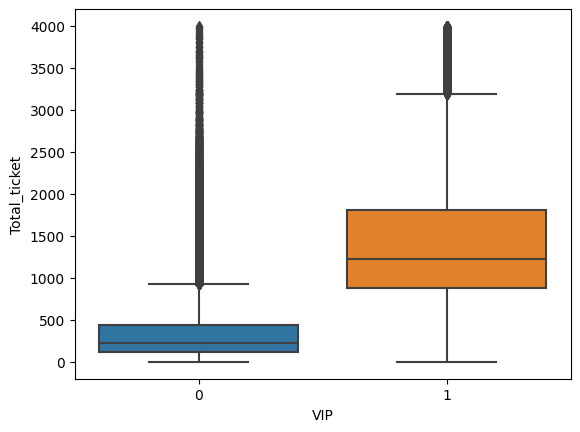

In [237]:
sns.boxplot(x=df_general['VIP'],y=df_general['Total_ticket'],data=df_general)

### Visualisation des variables qui ont la meilleure corrélation avec  la colonne VIP

C:\Users\benja\AppData\Local\Temp\ipykernel_26072\1733965797.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


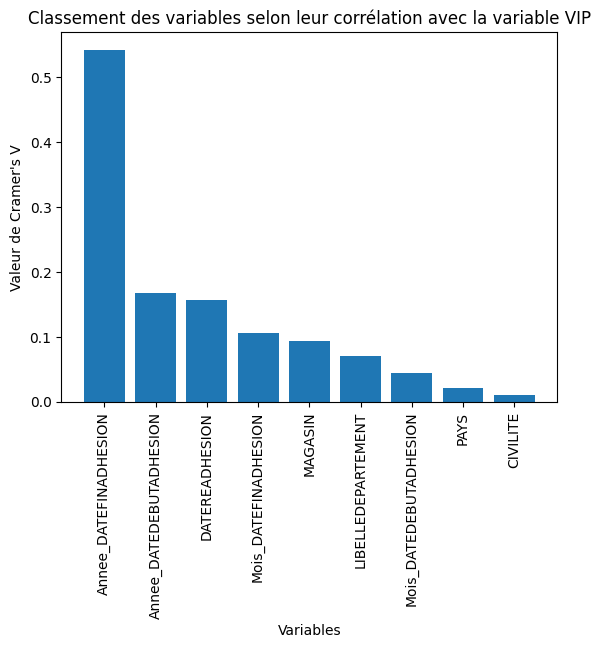

In [238]:
# Spécifier la variable cible
target_variable = 'VIP'

# Initialiser une liste vide pour stocker les résultats du test de Cramer's V
cramer_results = []

# Boucle à travers toutes les colonnes du dataframe
for column in colonne_qualit.columns:
    # Vérifier si la colonne est catégorielle
    if column != target_variable :
        # Effectuer le test de Cramer's V pour la colonne et la variable cible
        contingency_table = pd.crosstab(colonne_qualit[column], colonne_qualit[target_variable])
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        phi2 = chi2_stat/n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        
        # Ajouter le résultat du test de Cramer's V à la liste
        cramer_results.append({'Variable': column, 'Cramer\'s V': cramers_v})

# Trier la liste des résultats du test de Cramer's V par ordre décroissant de corrélation
cramer_results = sorted(cramer_results, key=lambda x: x['Cramer\'s V'], reverse=True)

# Extraire les noms de variables et les valeurs de Cramer's V en tant que listes
variable_names = [result['Variable'] for result in cramer_results]
cramer_values = [result['Cramer\'s V'] for result in cramer_results]

# Créer un histogramme des valeurs de Cramer's V
plt.bar(variable_names, cramer_values)
plt.xticks(rotation=90)
plt.title("Classement des variables selon leur corrélation avec la variable VIP")
plt.xlabel("Variables")
plt.ylabel("Valeur de Cramer's V")
plt.show()

Remarque : Nous décidons de nous séparer des variables "PAYS", "CIVILITE" et "IDCLIENT" Car leurs relations avec la variables "VIP" n'est pas significatif

### Suppression des Variables : Pays / Civilités / IDCLIENT

In [239]:
df_general=df_general.drop(['IDCLIENT','PAYS','CIVILITE'],axis=1)

# II/ Mise en place du modèle d'apprentissage : Régression Logistique

## Import bibliothèque

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


## Séparation de la variable cible des variables d'entrées

In [241]:
#Variables d'entrées
x = df_general.drop('VIP',axis=1)
#Variable Cible
y = df_general[['VIP']]

## Transformation des variables qualitatives en variables binaires (Dummification)

In [242]:
x=pd.DataFrame(pd.get_dummies(x))

## Séparation Test / entrainement

In [243]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=123
)

Remarque : 75 % du dataset seront notre jeu d'apprentissage et le reste sera notre jeu de test

## Normalisation des données quantitatives

In [244]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)


## Aplication du modèle d'apprentissage

In [245]:
#Definition des paramètres
params = {
    "penalty": "l2", 
    "C": 10, 
    "random_state": 42,
    "solver" : 'liblinear',
    "max_iter" :100
}
#Definition du modèle
clf = LogisticRegression(**params)

#Entrainement
clf=clf.fit(X_train, np.ravel(y_train))

#Prediction
y_pred = clf.predict(X_test)

## Evaluation du modèle

### Score Accuracy et AUC

In [246]:
##### Evalulation du modèle
print('Accuracy sur train = ', clf.score(X_train, y_train))  
print('Accuracy sur test = ', clf.score(X_test, y_test))
Accuracy_rl= clf.score(X_test, y_test)
###### AUC
print('AUC sur train = ', roc_auc_score(y_train, clf.predict(X_train)))  #AUC sur train =  0.856073573076948
print('AUC sur test = ', roc_auc_score(y_test, clf.predict(X_test))) #AUC sur test =  0.8568927254312381
AUC_rl= roc_auc_score(y_test, clf.predict(X_test))

Accuracy sur train =  0.9464264879257591
Accuracy sur test =  0.9465135596850789
AUC sur train =  0.8563357373945126
AUC sur test =  0.8571827954170997


Remarque : On observe dans notre cas une absence d'overfitting étant donnée que l'AUC du jeu d'apprentissage et du jeu de test sont similaires

### Matrice de confusion

Text(0.5, 23.52222222222222, 'Prédiction')

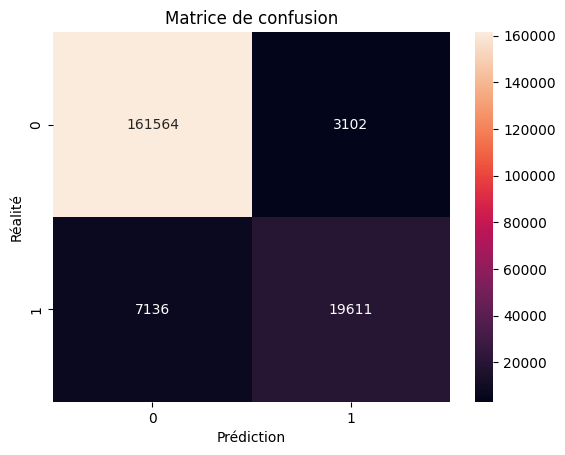

In [247]:
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cnf_matrix, annot=True, fmt="g")
plt.title("Matrice de confusion")
plt.ylabel("Réalité")
plt.xlabel("Prédiction")

### Metrics sur le jeux de test et courbe ROC

Precision: 0.863426231673491
Recall: 0.7332037237821064
F1 score: 0.7930044480388192


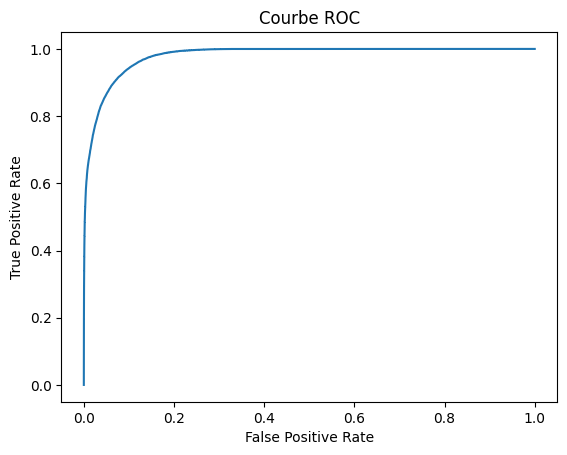

In [248]:
# Faire des prédictions sur les données de test
y_pred = clf.predict(X_test)

# Calculer les scores d'évaluation
precision_rl = precision_score(y_test, y_pred,pos_label='1')
recall_rl = recall_score(y_test, y_pred,pos_label='1')
f1_rl = f1_score(y_test, y_pred,pos_label='1')
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1],pos_label='1')

print("Precision:", precision_rl)
print("Recall:", recall_rl)
print("F1 score:", f1_rl)

# Afficher la courbe ROC
plt.plot(fpr, tpr)
plt.title('Courbe ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Remarque : Le changement de paramètre dans notre modèle n'a aucun impact sur l'évaluation du modèle. Pour obtenir un possible meilleur résultat, nous allons réaliser un second modèle d'apprentissage

# III/ Mise en place du modèle d'apprentissage : Random Forest

## Import bibliothèque

In [249]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


#Ici, je n'ai importé que la librairie manquante, les autres ont déjà été importées dans le grand II.

## Séparation de la variable cible des variables d'entrées

In [250]:
#Variables d'entrées
x = df_general.drop('VIP',axis=1)
#Variable Cible
y = df_general[['VIP']]

## Transformation des variables qualitatives en variables binaires (Dummification)

In [251]:
x=pd.DataFrame(pd.get_dummies(x))

## Séparation Test / entrainement

In [252]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=123
)

## Application du modèle d'apprentissage

In [253]:
X_train2 = pd.DataFrame(X_train)
X_test2 = pd.DataFrame(X_test)

### Recherche des meilleurs hyper-paramètres

In [ ]:
#rf=RandomForestClassifier(random_state=123)

#param_grid = { 
#   'n_estimators': [100, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [2,3,4,5],
#    'criterion' :['gini', 'entropy']
#}

#CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train2, y_train)

d:\Logiciels\Miniforge3\envs\datasc02\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Logiciels\Miniforge3\envs\datasc02\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
d:\Logiciels\Miniforge3\envs\datasc02\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Logiciels\Miniforge3\envs

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500]})

In [ ]:
#CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

### Modification de la profondeur (on varie de 8 à 15)

In [254]:
rf = RandomForestClassifier (criterion='entropy',max_depth= 14,max_features='auto',n_estimators= 500, random_state=123,n_jobs=1)
rf.fit(X_train2, y_train)

y_pred = rf.predict(X_test2)

C:\Users\benja\AppData\Local\Temp\ipykernel_26072\417161473.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train2, y_train)
c:\Users\benja\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


## Evaluation du modèle

### Score Accuracy et AUC

In [255]:
##### Evalulation du modèle
print('Accuracy sur train = ', rf.score(X_train2, y_train))  # Accuracy sur train =  0.9453406622931734        
print('Accuracy sur test = ', rf.score(X_test2, y_test))  # Accuracy sur test =  0.9437604485929229
Accuracy_rf= rf.score(X_test2, y_test)
###### AUC
print('AUC sur train = ', roc_auc_score(y_train, rf.predict(X_train2)))  # AUC sur train =  0.8251659857555569
print('AUC sur test = ', roc_auc_score(y_test, rf.predict(X_test2)))  # AUC sur test =  0.822481861536516
AUC_rf=roc_auc_score(y_test, rf.predict(X_test2))

Accuracy sur train =  0.9466803245042503
Accuracy sur test =  0.9450360476455837
AUC sur train =  0.8251659857555569
AUC sur test =  0.822481861536516


Remarque : On observe dans notre cas une absence d'overfitting étant donnée que l'AUC du jeu d'apprentissage et du jeu de test sont similaires

### Matrice de confusion

Text(0.5, 23.52222222222222, 'Prédiction')

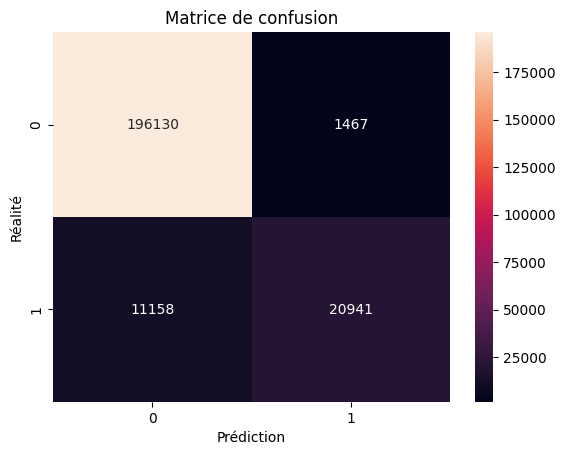

In [256]:

cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cnf_matrix, annot=True, fmt="g")
plt.title("Matrice de confusion")
plt.ylabel("Réalité")
plt.xlabel("Prédiction")

### Metrics sur le jeux de test et courbe ROC

Precision: 0.9345323098893252
Recall: 0.6523879248574722
F1 score: 0.7683783734199278


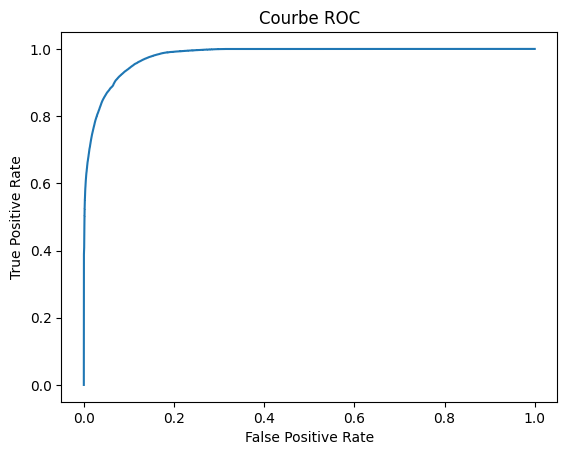

In [257]:
# Faire des prédictions sur les données de test
y_pred = rf.predict(X_test2)

# Calculer les scores d'évaluation
precision_rf = precision_score(y_test, y_pred,pos_label='1')
recall_rf = recall_score(y_test, y_pred,pos_label='1')
f1_rf = f1_score(y_test, y_pred,pos_label='1')
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1],pos_label='1')

print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 score:", f1_rf)

# Afficher la courbe ROC
plt.plot(fpr, tpr)
plt.title('Courbe ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# IV/Choix du modèle

## Comparaison des scores

In [259]:
print('Comparaison AUC :\n Regression logistique : {}\n Random forest : {}'.format(AUC_rl,AUC_rf))
print('Comparaison Accuracy :\n Regression logistique : {}\n Random forest : {}'.format(Accuracy_rl,Accuracy_rf))
print('Comparaison Precision :\n Regression logistique : {}\n Random forest : {}'.format(precision_rl,precision_rf))
print('Comparaison recall :\n Regression logistique : {}\n Random forest : {}'.format(recall_rl,recall_rf))
print('Comparaison F1 :\n Regression logistique : {}\n Random forest : {}'.format(f1_rl,f1_rf))

Comparaison AUC :
 Regression logistique : 0.8571827954170997
 Random forest : 0.822481861536516
Comparaison Accuracy :
 Regression logistique : 0.9465135596850789
 Random forest : 0.9450360476455837
Comparaison Precision :
 Regression logistique : 0.863426231673491
 Random forest : 0.9345323098893252
Comparaison recall :
 Regression logistique : 0.7332037237821064
 Random forest : 0.6523879248574722
Comparaison F1 :
 Regression logistique : 0.7930044480388192
 Random forest : 0.7683783734199278


## Conclusion


Après avoir observé les résultats, il est notable que la méthode de régression logistique présente des scores légèrement supérieurs à ceux de la méthode Random Forest. Par conséquent, dans notre cas, il serait préférable de choisir la régression logistique pour prédire les VIP.

Ces deux algorithmes, bien qu'ils diffèrents, fournissent tous deux des résultats satisfaisants, car ils parviennent tous deux à prédire correctement les VIP.